# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### Answer
---
This data represent 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Exploratory Data Analysis
---
Before diving into the rest of the problems, let's do some EDA

In [4]:
# Step 1: Handling Missing Values
# Columns with 'unknown' values
unknown_columns = [col for col in df.columns if 'unknown' in df[col].values]
print(f"Columns with 'unknown': {unknown_columns}")

# Strategy: Replace 'unknown' with NaN and decide imputation based on column type
df.replace('unknown', np.nan, inplace=True)

Columns with 'unknown': ['job', 'marital', 'education', 'default', 'housing', 'loan']


In [5]:
# Analyze missing data
def missing_data_summary(df):
    missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
    return missing_summary[missing_summary > 0]

missing_summary = missing_data_summary(df)
print("\nMissing Value Summary (%):")
print(missing_summary)


Missing Value Summary (%):
default      20.872584
education     4.202680
housing       2.403613
loan          2.403613
job           0.801204
marital       0.194231
dtype: float64


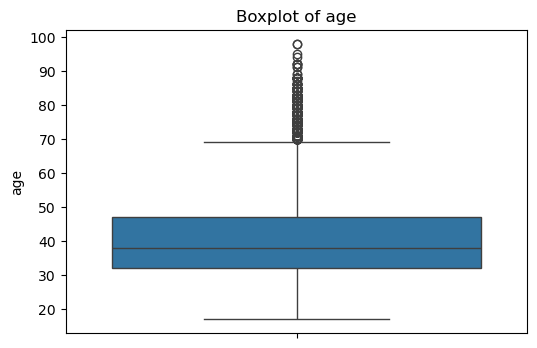

In [6]:
# Step 2: Handling Outliers
# Analyze numerical columns for outliers
#numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
# The only numeric feature we will considerate for our first model is age
numerical_columns = ['age']
# Visualization of outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

Even though there are some outliers in the age feature, these seem genuine data points and not data entry errors. We will train our models inclduing these outliers.

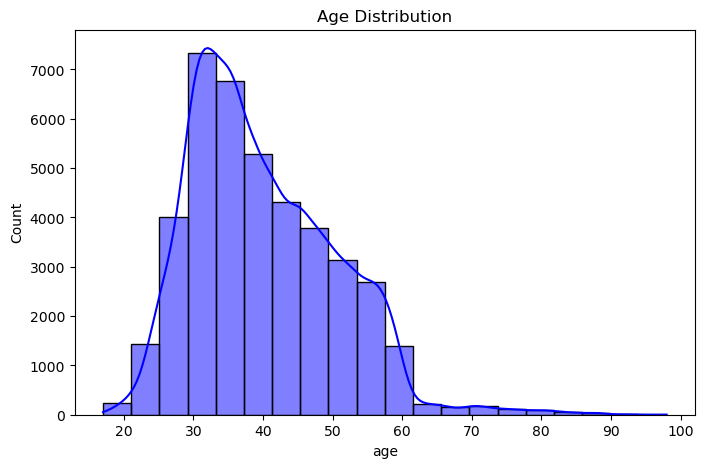

In [7]:
# Distribution of age
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], kde=True, bins=20, color='blue')
plt.title("Age Distribution")
plt.show()

<Figure size 1000x600 with 0 Axes>

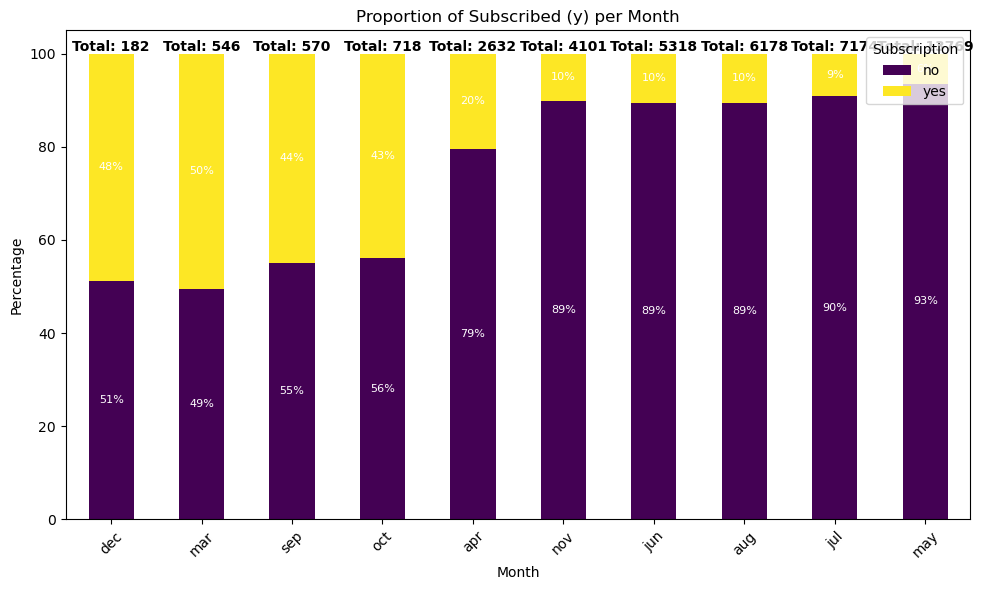

In [8]:
# Proportion of subscriptions per month
plt.figure(figsize=(10, 6))
month_subscription = df.groupby(['month', 'y']).size().unstack()
proportions = month_subscription.div(month_subscription.sum(axis=1), axis=0) * 100

# Order months by total observations
month_totals = month_subscription.sum(axis=1).sort_values()
proportions = proportions.loc[month_totals.index]

bar_plot = proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Add total count labels on each bar
for bar in bar_plot.containers:
    for rect in bar:
        bar_height = rect.get_height()
        bar_plot.text(
            rect.get_x() + rect.get_width() / 2, 
            rect.get_y() + bar_height / 2, 
            f'{int(bar_height)}%', 
            ha='center', va='center', fontsize=8, color='white'
        )

# Add total observations on top of each bar
for idx, total in enumerate(month_totals):
    bar_plot.text(
        idx, 
        100, 
        f'Total: {total}', 
        ha='center', va='bottom', fontsize=10, color='black', weight='bold'
    )

plt.title("Proportion of Subscribed (y) per Month")
plt.ylabel("Percentage")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Subscription", loc='upper right')
plt.tight_layout()
plt.show()

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Answer
---
By using `df.info()` it was observed that there are no missing values in this dataset; however, there are some "unknown" values that might need to be treated as missing values. All columns of type object will need to be encoded.

In [9]:
# Get the unique values for each feature of type object
object_columns = df.select_dtypes(include="object")
unique_values = {}
for col in object_columns:
    print(f'Column: {col}')
    print(object_columns[col].unique())

Column: job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']
Column: marital
['married' 'single' 'divorced' nan]
Column: education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']
Column: default
['no' nan 'yes']
Column: housing
['no' 'yes' nan]
Column: loan
['no' 'yes' nan]
Column: contact
['telephone' 'cellular']
Column: month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Column: day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
Column: poutcome
['nonexistent' 'failure' 'success']
Column: y
['no' 'yes']


In [10]:
# Get the value counts for each feature
for col in df.columns:
    print(f'Column: {col}')
    print(df[col].value_counts())

Column: age
age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64
Column: job
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: count, dtype: int64
Column: marital
marital
married     24928
single      11568
divorced     4612
Name: count, dtype: int64
Column: education
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: count, dtype: int64
Column: default
default
no     32588
yes        3
Name: count, dtype: int64
Column: housing
housing
yes    21576
no     18622
Name: count, dtype: int64
Column: loan
loan

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective
---
To explore different machine learning models and select the one that best predicts whether a customer will commit to a long-term deposit subscription. This will support the goal of getting more customer to subscribe with the least number of calls.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [12]:
# Remove 'unknown' values
df = df.replace('unknown', np.nan)
no_missing_values_df = df.dropna()

In [16]:
# One-hot encode categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])

In [20]:
# Encode target variable (yes: 1, no: 0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [22]:
# Standardize numerical features
scaler = StandardScaler()
scaled_age = scaler.fit_transform(df[['age']])

In [23]:
# Combine processed features
X = np.hstack([scaled_age, encoded_features])
y = df['y']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [24]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [26]:
# Establish a baseline model
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_accuracy

0.8865015780529255

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [27]:
# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Problem 9: Score the Model

What is the accuracy of your model?

In [28]:
logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_accuracy

0.8865015780529255

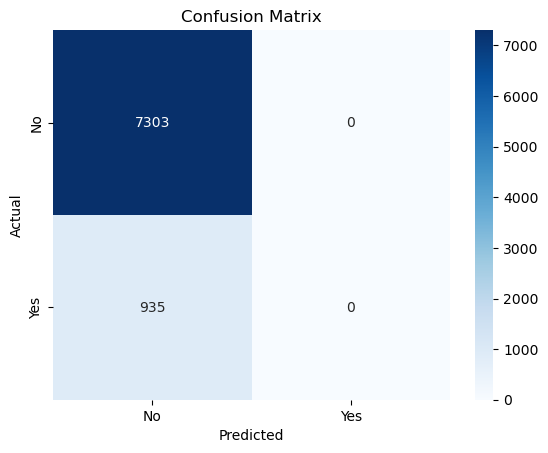

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, logistic_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [30]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42)
}

In [32]:
# Evaluate models
results = []
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    results.append({
        "Model": model_name,
        "Train Time": train_time,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    })

In [33]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                    Model  Train Time  Train Accuracy  Test Accuracy
0     Logistic Regression    0.086201        0.887557       0.886502
1     K-Nearest Neighbors    0.000979        0.889742       0.875212
2           Decision Tree    0.054082        0.916601       0.861010
3  Support Vector Machine   16.647160        0.888376       0.886623


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [35]:
# Hyperparameter grids
grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100]
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "Support Vector Machine": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"]
    }
}

In [ ]:
# Evaluate models with grid search
results = []
for model_name, model in models.items():
    print(f"\nStarting Grid Search for {model_name}...")
    grid = GridSearchCV(model, grids[model_name], scoring="accuracy", cv=5, n_jobs=-1)
    start_time = time.time()
    grid.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    best_model = grid.best_estimator_
    train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
    test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
    results.append({
        "Model": model_name,
        "Best Params": grid.best_params_,
        "Train Time": train_time,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    })


Starting Grid Search for Logistic Regression...

Starting Grid Search for K-Nearest Neighbors...

Starting Grid Search for Decision Tree...

Starting Grid Search for Support Vector Machine...


In [37]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison with Hyperparameter Tuning:")
print(results_df)


Model Comparison with Hyperparameter Tuning:
                    Model                               Best Params  \
0     Logistic Regression                               {'C': 0.01}   
1     K-Nearest Neighbors  {'n_neighbors': 9, 'weights': 'uniform'}   
2           Decision Tree  {'max_depth': 5, 'min_samples_split': 2}   
3  Support Vector Machine                 {'C': 1, 'kernel': 'rbf'}   

   Train Time (s)  Train Accuracy  Test Accuracy  
0        2.162160        0.887557       0.886502  
1        2.738724        0.890137       0.883710  
2        0.468902        0.888376       0.886866  
3      465.753604        0.888376       0.886623  


##### Questions